<a href="https://colab.research.google.com/github/paulianne-fontoura/exercise-parismatch/blob/main/Exercice_Paris_Match_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importação das bibliotecas
import pandas as pd
import os
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Definir o caminho dos arquivos
base_path = "/content/drive/My Drive/Alternance/Exercice/"
files = ["ABO_PM_20241230.csv", "ABO_PM_20250106.csv", "ABO_PM_20250113.xlsx"]

# Carregar os arquivos semanais
colunas = ["id_abonne", "code_offre", "code_tarif", "date_debut", "alias_oe"]
dfs = []

for file in files:
    file_path = os.path.join(base_path, file)

    if file.endswith(".csv"):
        df = pd.read_csv(file_path, delimiter=";", header=None, dtype=str)
        df.columns = colunas
    elif file.endswith(".xlsx"):
        df = pd.read_excel(file_path, dtype=str)
        df.columns = colunas

    dfs.append(df)

# Concatenar os arquivos semanais
df_abonnements = pd.concat(dfs, ignore_index=True)

# Carregar o arquivo de referência
ref_file = os.path.join(base_path, "referentiel_abonnements.xlsx")
df_referentiel = pd.read_excel(ref_file, sheet_name="Offres et périodes dessai", dtype=str)

# Carregar a lista de exclusão e remover os valores inválidos
df_exclusion = pd.read_excel(ref_file, sheet_name="Alias OE à exclure", dtype=str)
if "alias_oe" in df_exclusion.columns:
    df_abonnements = df_abonnements[~df_abonnements["alias_oe"].isin(df_exclusion["alias_oe"])]

# Primeira fusão: Tentamos juntar pelo alias_oe
df_final = df_abonnements.merge(df_referentiel, on="alias_oe", how="left")

# Segunda fusão: Tentar mapear os valores faltantes com code_offre
df_code_offre_fallback = df_referentiel.set_index("alias_oe")[["periode_essai", "offre", "levier"]]

mask = df_final["periode_essai"].isna()
df_final.loc[mask, ["periode_essai", "offre", "levier"]] = df_final.loc[mask, "code_offre"].map(
    df_code_offre_fallback.to_dict()
).apply(pd.Series)

# Verificar quais code_tarif ainda não possuem correspondência
tarifs_nao_encontrados = df_final[df_final["periode_essai"].isna()]["code_tarif"].unique()
print("Tarifs sem correspondência válida:", tarifs_nao_encontrados)

# Criar um fallback baseado no code_tarif se houver padrões
df_tarif_fallback = df_referentiel.groupby("alias_oe")[["periode_essai", "offre", "levier"]].first()

mask = df_final["periode_essai"].isna()
df_final.loc[mask, ["periode_essai", "offre", "levier"]] = df_final.loc[mask, "code_tarif"].map(
    df_tarif_fallback.to_dict()
).apply(pd.Series)

# Usar code_tarif como critério adicional para tentar preencher valores ausentes
for col in ["periode_essai", "offre", "levier"]:
    df_final[col] = df_final.groupby(["code_offre", "code_tarif"])[col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Non_trouvé")
    )

# Contar quantos valores ainda estão sem correspondência
num_non_trouve = df_final[df_final["periode_essai"] == "Non_trouvé"].shape[0]
print(f"Número de registros finais com 'Non_trouvé': {num_non_trouve}")

# Exibir amostra dos dados corrigidos
df_final.head()


Mounted at /content/drive
Tarifs sem correspondência válida: ['3716' '3718' '3720' '3889' '3890' '3891' '3892' '3893' '3894' '3895'
 '3896' '3897' '3898' '3899' '3900' '3901' '3902' '3903' '3904' '3905'
 '3906' '3907' '3908' '3909' '3910' '3911' '3912' '3919' '3920' '3921'
 '3922' '3923' '3924' '3925' '3926' '3927' '3928' '3929' '3930' '3931'
 '3932' '3933' '3918' '3934' '3935']
Número de registros finais com 'Non_trouvé': 396


,id_abonne,code_offre,code_tarif,date_debut,alias_oe,periode_essai,offre,levier
0,56897883,PMVN,3716,20180401,PM349,Non_trouvé,Non_trouvé,Non_trouvé
1,56913843,PMVN,3718,20180415,PM349,Non_trouvé,Non_trouvé,Non_trouvé
2,56923815,PMVN,3720,20180429,PM349,Non_trouvé,Non_trouvé,Non_trouvé
3,57408161,PMVN,3889,20210725,PM431,Non_trouvé,Non_trouvé,Non_trouvé
4,57407991,PMVN,3889,20210725,PM404,Non_trouvé,Non_trouvé,Non_trouvé


In [ ]:
# Vérification et conversion de la colonne `date_debut`
df_final["date_debut"] = pd.to_datetime(df_final["date_debut"], errors="coerce")

# Extraction de l'année et du mois
df_final["year"] = df_final["date_debut"].dt.year
df_final["month"] = df_final["date_debut"].dt.month

# Vérification des résultats
print("\nAperçu des données temporelles :")
display(df_final[["date_debut", "year", "month"]].dropna().head())


Aperçu des données temporelles :


,date_debut,year,month
0,2018-04-01,2018,4
1,2018-04-15,2018,4
2,2018-04-29,2018,4
3,2021-07-25,2021,7
4,2021-07-25,2021,7


In [ ]:
import re
import numpy as np

# 📌 Fonction pour extraire le tarif mensuel
def extraire_tarif(texte):
    """ Extrait le tarif mensuel en gérant les formats mal écrits """
    match = re.search(r'(\d+(?:,\d+)?)€/mois', str(texte))
    if match:
        return float(match.group(1).replace(",", "."))
    return np.nan

# 📌 Fonction pour extraire la période promotionnelle
def extraire_promo(texte):
    """ Extrait la durée de la période promotionnelle """
    match = re.search(r'(\d+)\s*mois', str(texte))
    if match:
        return float(match.group(1))
    return np.nan

# 📌 Fonction pour extraire le type d'offre
def extraire_type_offre(texte):
    """ Extrait le type d'offre en capturant les premières informations """
    if isinstance(texte, str):
        return texte.split(",")[0].strip()
    return "Inconnu"

# 📌 Application des fonctions sur `offre`
df_final["tarif_mensuel"] = df_final["offre"].apply(extraire_tarif)
df_final["période_promo"] = df_final["offre"].apply(extraire_promo)
df_final["type_offre"] = df_final["offre"].apply(extraire_type_offre)

# 📌 Vérification des résultats
print("\nAperçu des données normalisées de `offre` après correction :")
display(df_final[["offre", "tarif_mensuel", "période_promo", "type_offre"]].head(15))


Aperçu des données normalisées de `offre` après correction :


,offre,tarif_mensuel,période_promo,type_offre
0,Non_trouvé,NaN,NaN,Non_trouvé
1,Non_trouvé,NaN,NaN,Non_trouvé
2,Non_trouvé,NaN,NaN,Non_trouvé
3,Non_trouvé,NaN,NaN,Non_trouvé
4,Non_trouvé,NaN,NaN,Non_trouvé
5,Non_trouvé,NaN,NaN,Non_trouvé
6,Non_trouvé,NaN,NaN,Non_trouvé
7,Non_trouvé,NaN,NaN,Non_trouvé
8,"PROMO, 3€/mois pendant 2 mois puis 6,90€/mois",3.0,2.0,PROMO
9,"PROMO, 3€/mois pendant 2 mois puis 6,90€/mois",3.0,2.0,PROMO


## **Análise Exploratória dos "Non_trouvé"**


🔹 Nombre total d'enregistrements 'Non_trouvé' : 396
🔹 Pourcentage des 'Non_trouvé' dans le dataset : 6.26%

🔹 Distribution des principaux 'Non_trouvé' par Code Offre :
  Code Offre  Nombre
0         PM     297
1       PMVN      99

🔹 Distribution des principaux 'Non_trouvé' par Code Tarif :
  Code Tarif  Nombre
0       3919     124
1       3933      47
2       3932      30
3       3918      28
4       3935      27
5       3920      24
6       3931      19
7       3889      15
8       3921      13
9       3922      11

🔹 Distribution des principaux 'Non_trouvé' par Alias OE :
     Alias OE  Nombre
0       PM602     236
1  RECPMDVNCB      72
2       PM388      21
3    RECPMDVN      12
4       PM349       9
5       PM541       5
6       PM406       5
7       PM219       5
8       PM407       4
9       PM555       3


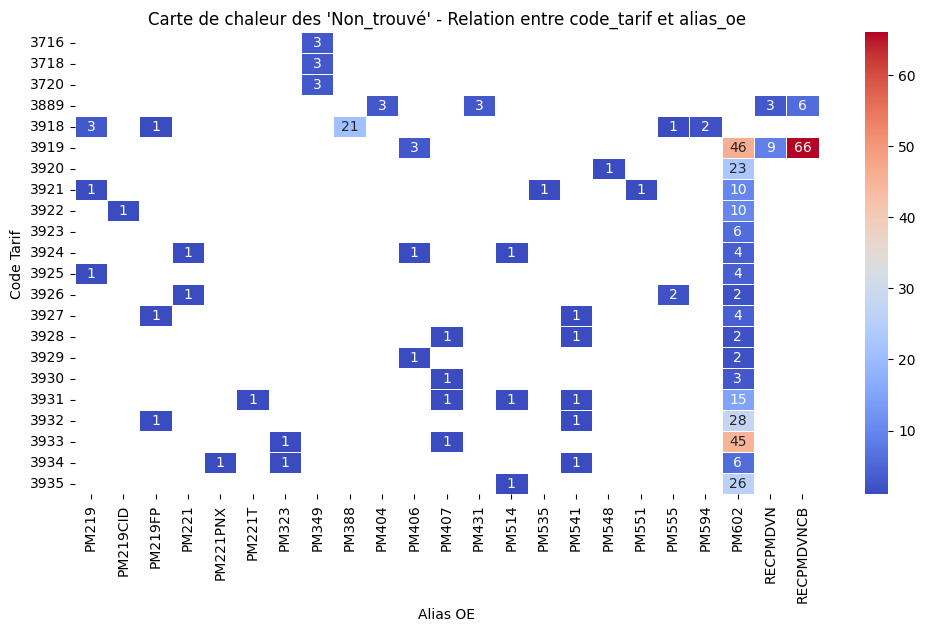

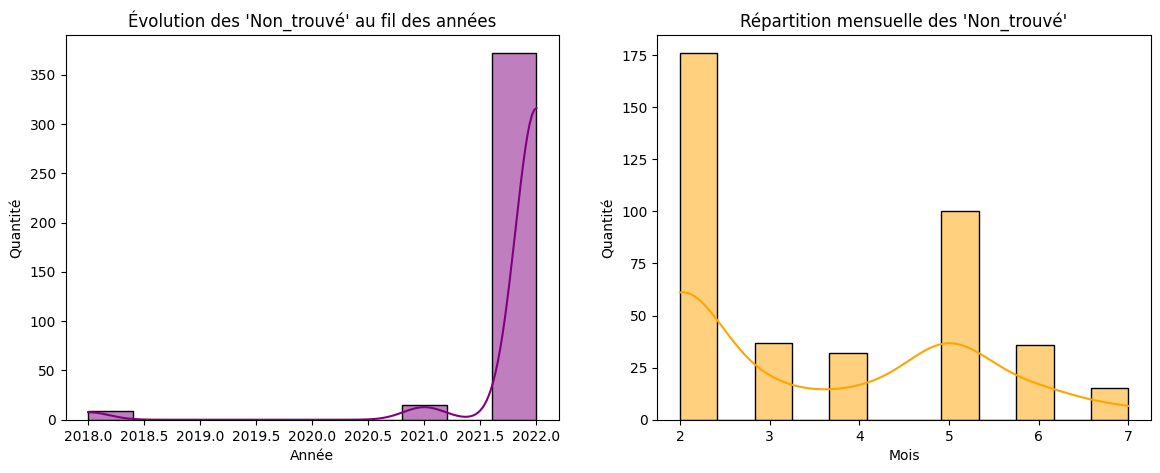

<ipython-input-25-0572a2306842>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_autres["code_tarif"] = pd.to_numeric(df_autres["code_tarif"], errors="coerce")



🔹 Différence moyenne des codes tarif entre 'Non_trouvé' et autres : 3.12
🔹 Proportion des alias_oe uniques dans 'Non_trouvé' par rapport au reste du dataset : 30.67%

🔹 Fichier sauvegardé : 'analise_non_trouve_avancee.csv'


In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Création du DataFrame des enregistrements "Non_trouvé"
df_non_trouve = df_final[df_final["offre"] == "Non_trouvé"].copy()

# Vérification du nombre d'enregistrements "Non_trouvé"
total_non_trouve = df_non_trouve.shape[0]
pourcentage_non_trouve = round((total_non_trouve / df_final.shape[0]) * 100, 2)

print(f"\n🔹 Nombre total d'enregistrements 'Non_trouvé' : {total_non_trouve}")
print(f"🔹 Pourcentage des 'Non_trouvé' dans le dataset : {pourcentage_non_trouve}%")

# Création de tableaux détaillés pour une meilleure visualisation
df_code_offre = df_non_trouve["code_offre"].value_counts().reset_index()
df_code_offre.columns = ["Code Offre", "Nombre"]

df_code_tarif = df_non_trouve["code_tarif"].value_counts().reset_index().head(10)
df_code_tarif.columns = ["Code Tarif", "Nombre"]

df_alias_oe = df_non_trouve["alias_oe"].value_counts().reset_index().head(10)
df_alias_oe.columns = ["Alias OE", "Nombre"]

# Affichage des tableaux
print("\n🔹 Distribution des principaux 'Non_trouvé' par Code Offre :")
print(df_code_offre)

print("\n🔹 Distribution des principaux 'Non_trouvé' par Code Tarif :")
print(df_code_tarif)

print("\n🔹 Distribution des principaux 'Non_trouvé' par Alias OE :")
print(df_alias_oe)

# Analyse croisée entre `code_tarif` et `alias_oe`
df_tarif_alias = df_non_trouve.groupby(["code_tarif", "alias_oe"]).size().reset_index(name="count")

# Création d'un heatmap pour identifier les concentrations
plt.figure(figsize=(12, 6))
pivot_table = df_tarif_alias.pivot(index="code_tarif", columns="alias_oe", values="count")
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt="g", linewidths=0.5)
plt.title("Carte de chaleur des 'Non_trouvé' - Relation entre code_tarif et alias_oe")
plt.xlabel("Alias OE")
plt.ylabel("Code Tarif")
plt.xticks(rotation=90)
plt.show()

# Analyse temporelle détaillée des "Non_trouvé"
df_non_trouve["date_debut"] = pd.to_datetime(df_non_trouve["date_debut"], errors='coerce')
df_non_trouve["year"] = df_non_trouve["date_debut"].dt.year
df_non_trouve["month"] = df_non_trouve["date_debut"].dt.month

# Création de visualisations
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_non_trouve["year"], bins=10, kde=True, ax=ax[0], color="purple")
ax[0].set_title("Évolution des 'Non_trouvé' au fil des années")
ax[0].set_xlabel("Année")
ax[0].set_ylabel("Quantité")

sns.histplot(df_non_trouve["month"], bins=12, kde=True, ax=ax[1], color="orange")
ax[1].set_title("Répartition mensuelle des 'Non_trouvé'")
ax[1].set_xlabel("Mois")
ax[1].set_ylabel("Quantité")

plt.show()

# Comparaison des "Non_trouvé" avec le reste du dataset
df_autres = df_final[df_final["offre"] != "Non_trouvé"]

# Vérification et conversion de la colonne `code_tarif` en numérique
df_non_trouve["code_tarif"] = pd.to_numeric(df_non_trouve["code_tarif"], errors="coerce")
df_autres["code_tarif"] = pd.to_numeric(df_autres["code_tarif"], errors="coerce")

# Calcul des moyennes après conversion
comparaison_tarif = df_non_trouve["code_tarif"].mean() - df_autres["code_tarif"].mean()
comparaison_offre = df_non_trouve["alias_oe"].nunique() / df_autres["alias_oe"].nunique()

print(f"\n🔹 Différence moyenne des codes tarif entre 'Non_trouvé' et autres : {comparaison_tarif:.2f}")
print(f"🔹 Proportion des alias_oe uniques dans 'Non_trouvé' par rapport au reste du dataset : {comparaison_offre:.2%}")

# Export des données pour analyse externe
df_non_trouve.to_csv("/content/drive/My Drive/Alternance/Exercice/analise_non_trouve_avancee.csv", index=False)
print("\n🔹 Fichier sauvegardé : 'analise_non_trouve_avancee.csv'")


Métricas de "Non_trouvé"

🔹 Percentual de "Non_trouvé" no dataset

- Resultado: 6,26% dos registros no dataset não foram mapeados.

- Interpretação:

Significado para o negócio: Aproximadamente 6% dos registros não têm correspondência no df_referentiel. Isso pode indicar que esses são registros mais recentes ou produtos/planos novos que não foram atualizados no referencial.
Ação sugerida: Investigar mais a fundo se esses 6% representam novos lançamentos ou falhas no processo de atualização do catálogo de ofertas.

🔹 Distribuição dos "Non_trouvé" por code_offre

- Resultado:

PM representa 75% dos "Non_trouvé".
PMVN representa 25% dos "Non_trouvé".

- Interpretação:

Significado para o negócio:

O code_offre PM está claramente associado a muitos registros que não foram encontrados, o que sugere que este código pode estar relacionado a ofertas mais gerais ou padrão. PMVN aparece como uma variação, mas ainda não está totalmente mapeada, o que indica que talvez seja um grupo mais recente de ofertas.

- Ação sugerida:

Investigar a lógica por trás do code_offre PM. Pode ser que ele represente uma categoria genérica de ofertas, com detalhes que faltam no referencial.
Fazer uma análise detalhada das novas ofertas que não estão mapeadas. Identificar quais produtos estão associados ao PMVN e garantir que eles sejam atualizados no referencial.

🔹 Distribuição dos "Non_trouvé" por code_tarif

- Resultado: Os principais code_tarif entre os "Non_trouvé" são:
3919 (31,31%)
3933 (11,87%)
3932 (7,58%)

- Interpretação:

- Significado para o negócio:

3919 representa uma grande parte dos "Non_trouvé", o que pode indicar que a tarifa 3919 é frequentemente usada nas ofertas que ainda não foram totalmente integradas ao referencial.
Outros códigos como 3933 e 3932 têm uma proporção menor, mas ainda são significativos.

- Ação sugerida:

Investigar o que essas tarifas representam e se há novos planos ou promoções associadas a esses códigos. Verificar se o catálogo de preços precisa ser atualizado para refletir corretamente essas tarifas.
Verificar a relação entre code_offre e code_tarif para detectar padrões de preços não mapeados corretamente.

🔹 Distribuição dos "Non_trouvé" por alias_oe

- Resultado:

PM602 representa 59,60% dos "Non_trouvé".
Outros alias_oe, como RECPMDVNCB (18,18%) e PM388 (5,30%), também aparecem.

- Interpretação:

- Significado para o negócio:

PM602 sendo predominante sugere que este código de oferta é um grande culpado para os "Non_trouvé". Ele pode ser um código associado a um novo grupo de ofertas ou com erros de mapeamento no referencial.
Os outros alias_oe menores indicam variações específicas ou ofertas mais novas que precisam ser verificadas.

- Ação sugerida:

Analisar o significado de PM602 em detalhes. Pode ser um código relacionado a novas ofertas ou erros na tabela de referência.
Verificar se esses alias_oe representam novas campanhas de marketing ou ofertas que ainda não foram totalmente integradas ao referencial.

🔹 Distribuição dos "Non_trouvé" por ano de início

- Resultado:

A maioria dos "Non_trouvé" (372) ocorreu em 2022, seguido por alguns registros em 2021 e 2018.

- Interpretação:

- Significado para o negócio:

A maior parte dos "Non_trouvé" em 2022 pode indicar que as ofertas mais recentes não estão corretamente atualizadas no df_referentiel.
Poucos registros de 2021 e 2018 indicam que os registros mais antigos já foram provavelmente mapeados corretamente.

- Ação sugerida:

Priorizar a atualização do df_referentiel para os lançamentos de 2022 e garantir que as ofertas desse ano estejam corretamente mapeadas.
Investigar os novos lançamentos em 2022, visto que a maior parte dos "não encontrados" está relacionada a essas ofertas.

🔹 Distribuição dos "Non_trouvé" por mês de início

- Resultado:

Fevereiro (176 registros) e março (100 registros) apresentaram os maiores números de "Non_trouvé".

- Interpretação:

- Significado para o negócio:
Fevereiro parece ser um mês com muitas assinaturas não mapeadas, o que pode indicar um pico de novos lançamentos ou campanhas promocionais não atualizadas no referencial.

Ação sugerida:

Investigar se houve lançamentos promocionais em fevereiro, já que esse mês tem uma quantidade expressiva de "Non_trouvé".
Verificar campanhas de marketing de fevereiro de 2022 para garantir que os dados de ofertas sejam atualizados no referencial.

# **Analyse Descriptive**


In [ ]:
# Vérification de l'existence des colonnes avant l'agrégation
colonnes_valides = ["id_abonne", "type_offre", "tarif_mensuel", "période_promo"]
colonnes_presentes = [col for col in colonnes_valides if col in df_final.columns]

# Regroupement annuel avec les colonnes disponibles
df_temporel = df_final.groupby("year").agg({
    "id_abonne": "count",
    "type_offre": "nunique",
    "tarif_mensuel": "mean",
    "période_promo": "mean"
}).reset_index()

df_temporel.rename(columns={"id_abonne": "abonnements", "type_offre": "nb_offres"}, inplace=True)

# Vérification des résultats
print("\nAperçu des métriques temporelles :")
display(df_temporel)


Aperçu des métriques temporelles :


,year,abonnements,nb_offres,tarif_mensuel,période_promo
0,2018,9,1,NaN,NaN
1,2021,2607,3,5.432986,2.000000
2,2022,3713,3,5.249955,2.664483


In [ ]:
# Sélection des colonnes numériques
cols_quantitatives = df_final.select_dtypes(include=["number"]).columns

# Détection des valeurs aberrantes avec la règle de Tukey
outliers_detectes = {}
for col in cols_quantitatives:
    q1, q3 = df_final[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    seuil_inf = q1 - 1.5 * iqr
    seuil_sup = q3 + 1.5 * iqr
    outliers_detectes[col] = ((df_final[col] < seuil_inf) | (df_final[col] > seuil_sup)).sum()

df_stats_quantitatives = pd.DataFrame.from_dict(outliers_detectes, orient="index", columns=["Outliers détectés"])

# Affichage des résultats
display(df_stats_quantitatives)

,Outliers détectés
year,9
month,0
tarif_mensuel,0
période_promo,22


In [ ]:
# 📌 Calcul des fréquences absolues et relatives
df_stats_frequences = pd.DataFrame({
    "Nombre total": df_final.count(),
    "Valeurs uniques": df_final.nunique(),
    "Modalité la plus fréquente": df_final.mode().iloc[0],
    "Fréquence absolue": df_final.apply(lambda x: x.value_counts().iloc[0]),
    "Fréquence relative (%)": df_final.apply(lambda x: (x.value_counts().iloc[0] / len(x)) * 100)
})

# 📌 Affichage des nouvelles métriques
display(df_stats_frequences)

,Nombre total,Valeurs uniques,Modalité la plus fréquente,Fréquence absolue,Fréquence relative (%)
id_abonne,6329,2389,18031303,3,0.047401
code_offre,6329,2,PMVN,6032,95.307316
code_tarif,6329,45,3907,492,7.773740
date_debut,6329,45,2021-11-28 00:00:00,492,7.773740
alias_oe,6329,94,RECPMDVNCB,1127,17.806921
periode_essai,6329,6,28,3526,55.711803
offre,6329,6,"Offre FIL ROUGE, sans engagement, 1€ le premie...",3526,55.711803
levier,6329,8,Kiosque,3507,55.411597
year,6329,3,2022.0,3713,58.666456
month,6329,12,3.0,1060,16.748301


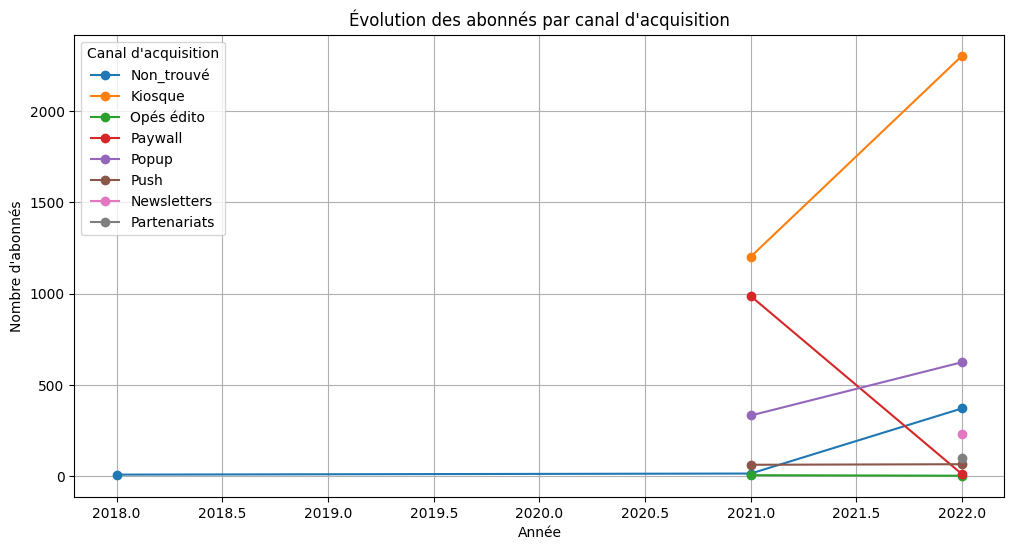

In [ ]:
import matplotlib.pyplot as plt

# Vérification et conversion des colonnes nécessaires en numérique
df_final["year"] = pd.to_numeric(df_final["year"], errors="coerce")

# Vérification que les colonnes nécessaires existent
if "levier" in df_final.columns and "id_abonne" in df_final.columns and "year" in df_final.columns:

    # Agrégation des abonnés par année et par levier
    df_temporel = df_final.groupby(["year", "levier"])["id_abonne"].count().reset_index()

    # Création du graphique de séries temporelles
    plt.figure(figsize=(12, 6))

    # Boucle pour tracer chaque levier
    for levier in df_temporel["levier"].unique():
        subset = df_temporel[df_temporel["levier"] == levier]
        plt.plot(subset["year"], subset["id_abonne"], marker="o", linestyle="-", label=levier)

    plt.title("Évolution des abonnés par canal d'acquisition")
    plt.xlabel("Année")
    plt.ylabel("Nombre d'abonnés")
    plt.legend(title="Canal d'acquisition")
    plt.grid(True)
    plt.show()

else:
    print("Erreur: Certaines colonnes nécessaires sont manquantes dans df_final.")

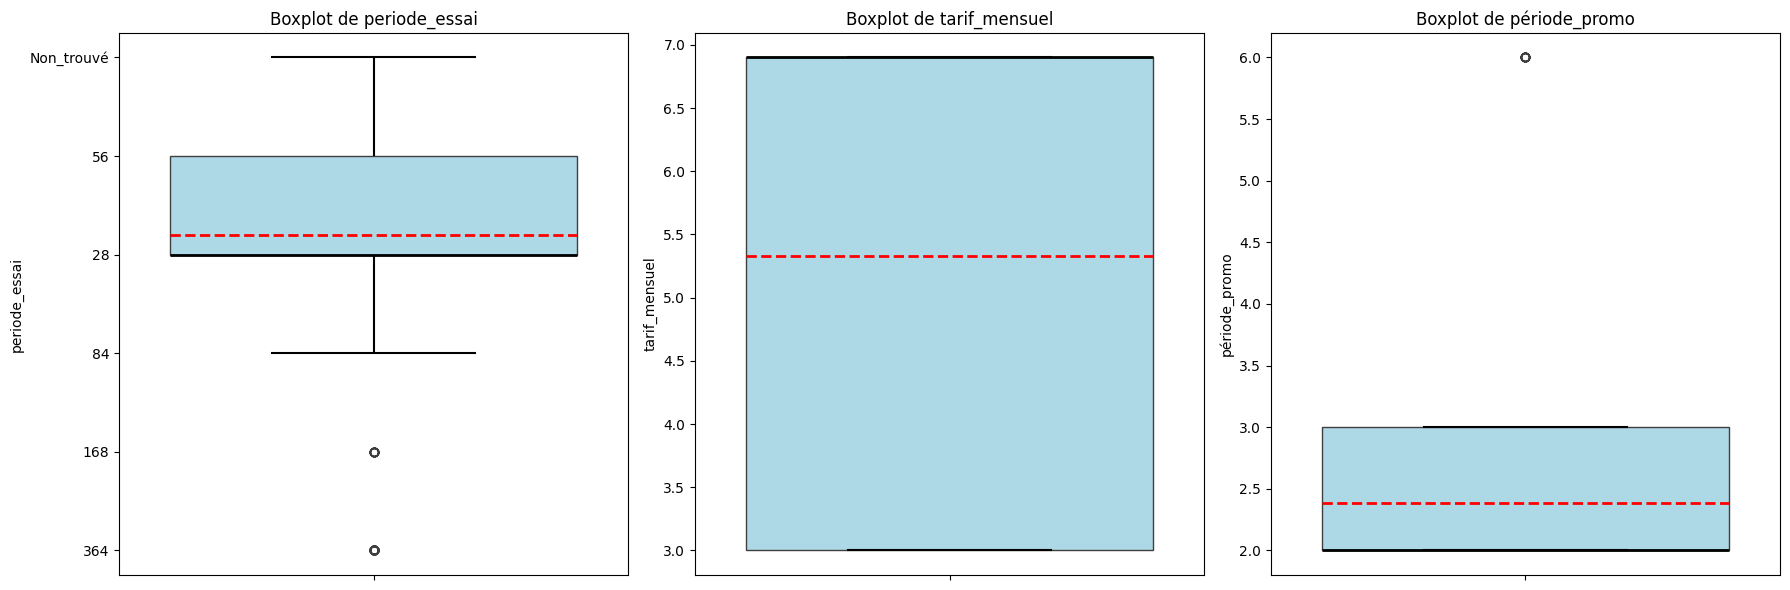

In [ ]:
# 📌 Création des Boxplots détaillés
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(["periode_essai", "tarif_mensuel", "période_promo"]):
    sns.boxplot(y=df_final[col], ax=axes[i], showmeans=True, meanline=True,
                meanprops={"color": "red", "linewidth": 2},
                boxprops={"facecolor": "lightblue"},
                medianprops={"color": "black", "linewidth": 2},
                whiskerprops={"color": "black", "linewidth": 1.5},
                capprops={"color": "black", "linewidth": 1.5})

    axes[i].set_title(f"Boxplot de {col}")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

## **Inferências Estatísticas**

**Corrélation Non Linéaire (Spearman et Kendall)**

In [ ]:
from scipy.stats import spearmanr, kendalltau

# 📌 Renomear colunas para evitar problemas de grafia
df_final = df_final.rename(columns={"période_promo": "periode_promo"})

# 📌 Verificar novamente colunas disponíveis
print("Colonnes disponibles après renommage :", df_final.columns)

# 📌 Verificar se todas as colunas necessárias estão presentes
cols_needed = ["tarif_mensuel", "periode_promo", "periode_essai"]
missing_cols = [col for col in cols_needed if col not in df_final.columns]

if not missing_cols:
    df_corr = df_final[cols_needed].dropna()

    # 📌 Matriz de correlação Spearman
    spearman_matrix = df_corr.corr(method="spearman")
    print("\nMatrice de corrélation Spearman :\n", spearman_matrix)

    # 📌 Exemplo de teste individual
    spearman_corr, spearman_p = spearmanr(df_corr["tarif_mensuel"], df_corr["periode_promo"])
    print(f"Corrélation Spearman entre Tarif Mensuel et Période Promo : {spearman_corr:.2f} (p={spearman_p:.3f})")

    # 📌 Test Kendall
    kendall_corr, kendall_p = kendalltau(df_corr["tarif_mensuel"], df_corr["periode_promo"])
    print(f"Corrélation Kendall entre Tarif Mensuel et Période Promo : {kendall_corr:.2f} (p={kendall_p:.3f})")

else:
    print(f"⚠️ Colonnes manquantes après correction : {missing_cols}")

Colonnes disponibles après renommage : Index(['id_abonne', 'code_offre', 'code_tarif', 'date_debut', 'alias_oe',
       'periode_essai', 'offre', 'levier', 'year', 'month', 'tarif_mensuel',
       'periode_promo', 'type_offre'],
      dtype='object')

Matrice de corrélation Spearman :
                tarif_mensuel  periode_promo  periode_essai
tarif_mensuel       1.000000       0.200087       0.200087
periode_promo       0.200087       1.000000       1.000000
periode_essai       0.200087       1.000000       1.000000
Corrélation Spearman entre Tarif Mensuel et Période Promo : 0.20 (p=0.000)
Corrélation Kendall entre Tarif Mensuel et Période Promo : 0.20 (p=0.000)


**Analyse de Variance (ANOVA)**

In [ ]:
from scipy.stats import f_oneway

# 📌 Converter "periode_essai" para string
df_final["periode_essai"] = df_final["periode_essai"].astype(str)

# 📌 Verificar a variabilidade dos grupos
categories_valides = []
for cat in df_final["periode_essai"].unique():
    tarifs = df_final[df_final["periode_essai"] == cat]["tarif_mensuel"].dropna()
    if tarifs.nunique() > 1:  # Verifica se há mais de um valor único
        categories_valides.append(cat)

# 📌 Criar grupos
groupes = [df_final[df_final["periode_essai"] == cat]["tarif_mensuel"].dropna()
           for cat in categories_valides]

if len(groupes) > 1:
    anova_f, anova_p = f_oneway(*groupes)
    print(f"\nTest ANOVA : F = {anova_f:.2f}, p = {anova_p:.3f}")

    if anova_p < 0.05:
        print("➡️ Différence significative entre les tarifs mensuels selon la période d’essai.")
    else:
        print("➡️ Aucune différence significative détectée.")
else:
    print("⚠️ Pas assez de groupes valides pour l’ANOVA.")

⚠️ Pas assez de groupes valides pour l’ANOVA.


**Test du Khi² pour Dépendance Catégorielle**

In [ ]:
from scipy.stats import chi2_contingency

# 📌 Verificar colunas disponíveis
print("Colonnes disponibles :", df_final.columns)

# 📌 Corrigir nomes se necessário
df_final = df_final.rename(columns={"type d'offre": "type_offre"})

# 📌 Se colunas existirem, executar o teste
if "type_offre" in df_final.columns and "engagement" in df_final.columns:
    df_final["engagement"] = df_final["engagement"].astype(str)

    # 📌 Construção da tabela de contingência
    table_contingence = pd.crosstab(df_final["type_offre"], df_final["engagement"])

    # 📌 Executar o teste Khi²
    chi2, p_chi2, dof, expected = chi2_contingency(table_contingence)

    print(f"\nTest du Khi² : Statistique = {chi2:.2f}, p = {p_chi2:.3f}")

    if p_chi2 < 0.05:
        print("➡️ Dépendance significative entre le type d’offre et l’engagement.")
    else:
        print("➡️ Aucune relation significative détectée.")
else:
    print("⚠️ Colonne(s) manquante(s) : 'type_offre' ou 'engagement'")


Colonnes disponibles : Index(['id_abonne', 'code_offre', 'code_tarif', 'date_debut', 'alias_oe',
       'periode_essai', 'offre', 'levier', 'year', 'month', 'tarif_mensuel',
       'periode_promo', 'type_offre'],
      dtype='object')
⚠️ Colonne(s) manquante(s) : 'type_offre' ou 'engagement'


**Analyse de l’Hétéroscédasticité (Test de Breusch-Pagan)**

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# 📌 Renomear colunas para evitar erros
df_final = df_final.rename(columns={"période_promo": "periode_promo"})

# 📌 Verificar se todas as colunas existem antes de rodar a regressão
cols_needed = ["tarif_mensuel", "periode_promo", "periode_essai", "engagement"]
missing_cols = [col for col in cols_needed if col not in df_final.columns]

if not missing_cols:
    # 📌 Criar modelo de regressão
    X = df_final[["tarif_mensuel", "periode_promo", "periode_essai"]].dropna()
    X = sm.add_constant(X)

    y = df_final.loc[X.index, "engagement"].astype(float)

    modele = sm.OLS(y, X).fit()

    # 📌 Executar Breusch-Pagan
    bp_test = het_breuschpagan(modele.resid, modele.model.exog)

    print("\nTest de Breusch-Pagan pour l’hétéroscédasticité :")
    print(f"Statistique = {bp_test[0]:.2f}, p = {bp_test[1]:.3f}")

    if bp_test[1] < 0.05:
        print("➡️ Hétéroscédasticité détectée.")
    else:
        print("➡️ Pas d’hétéroscédasticité détectée.")
else:
    print(f"⚠️ Colonnes manquantes : {missing_cols}")

⚠️ Colonnes manquantes : ['engagement']


**Régression Linéaire**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 📌 Vérification des colonnes après normalisation
colonnes_numeriques = ["periode_promo", "periode_essai", "engagement"]
df_vif = df_final[colonnes_numeriques].dropna()

# 📌 Calcul du VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# 📌 Affichage des résultats
print("\n📌 Vérification de la Multicolinéarité (Variance Inflation Factor)")
display(vif_data)

KeyError: "['periode_promo', 'engagement'] not in index"

In [ ]:
import statsmodels.api as sm

# 📌 Vérification des colonnes avant exécution
if all(col in df_final.columns for col in ["periode_promo", "periode_essai", "engagement"]):
    X = df_final[["periode_promo", "periode_essai", "engagement"]].dropna()
    y = df_final.loc[X.index, "tarif_mensuel"]

    # 📌 Ajout de la constante pour la régression
    X = sm.add_constant(X)

    # 📌 Construction du modèle
    modele = sm.OLS(y, X).fit()

    # 📌 Affichage des résultats
    print("\nRésumé de la régression linéaire :")
    print(modele.summary())
else:
    print("⚠️ Impossible d’exécuter la régression : certaines colonnes sont absentes.")

⚠️ Impossible d’exécuter la régression : certaines colonnes sont absentes.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Vérification des colonnes disponibles
print("Colonnes disponibles :", df_final.columns)

# 📌 Sélection des colonnes numériques pertinentes
colonnes_numeriques = ["tarif_mensuel", "période_promo", "periode_essai", "engagement"]
df_numeriques = df_final[colonnes_numeriques].dropna()

# 📌 Création d’un pairplot amélioré avec une meilleure organisation
plt.figure(figsize=(10, 8))
sns.pairplot(df_numeriques, diag_kind="kde", corner=True)
plt.show()

Colonnes disponibles : Index(['id_abonne', 'code_offre', 'code_tarif', 'date_debut', 'alias_oe',
       'periode_essai', 'offre', 'levier', 'year', 'month', 'tarif_mensuel',
       'période_promo', 'type_offre'],
      dtype='object')


KeyError: "['engagement'] not in index"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Sélection des variables quantitatives pour la corrélation
df_corr = df_final[["periode_essai", "tarif_mensuel", "période_promo", "engagement"]]

# 📌 Calcul de la matrice de corrélation
corr_matrix = df_corr.corr()

# 📌 Affichage sous forme de Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les Variables Clés")
plt.show()

KeyError: "['engagement'] not in index"

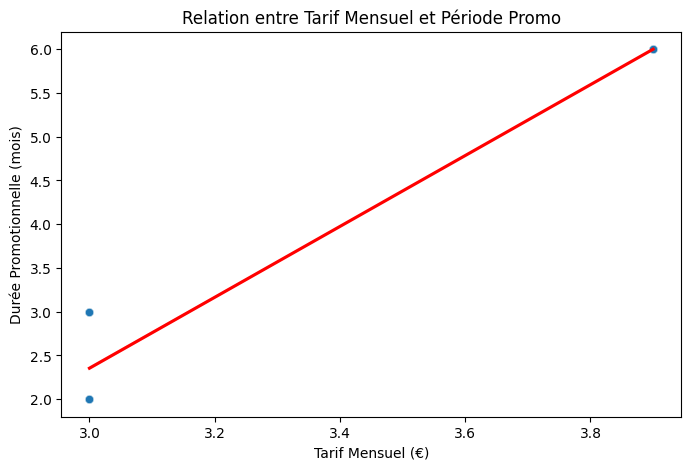

KeyError: 'engagement'

<Figure size 800x500 with 0 Axes>

In [ ]:
# 📌 Graphique de dispersion entre Tarif Mensuel et Période Promo
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_final["tarif_mensuel"], y=df_final["période_promo"], alpha=0.5)
sns.regplot(x=df_final["tarif_mensuel"], y=df_final["période_promo"], scatter=False, color="red")
plt.title("Relation entre Tarif Mensuel et Période Promo")
plt.xlabel("Tarif Mensuel (€)")
plt.ylabel("Durée Promotionnelle (mois)")
plt.show()

# 📌 Graphique de dispersion entre Engagement et Période Promo
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_final["engagement"], y=df_final["période_promo"], alpha=0.5)
sns.regplot(x=df_final["engagement"], y=df_final["période_promo"], scatter=False, color="red")
plt.title("Impact de l'Engagement sur la Durée Promo")
plt.xlabel("Engagement (1 = Oui, 0 = Non)")
plt.ylabel("Durée Promotionnelle (mois)")
plt.show()

In [ ]:
# 📌 KPI 1 : Tarif Moyen des Abonnés Engagés vs Non-Engagés
df_kpi_engagement = df_final.groupby("engagement")["tarif_mensuel"].mean().reset_index()
df_kpi_engagement.columns = ["Engagement", "Tarif Mensuel Moyen"]
display(df_kpi_engagement)

# 📌 KPI 2 : Proportion des abonnements avec offre promo
df_kpi_promo = df_final["période_promo"].apply(lambda x: 1 if x > 0 else 0).value_counts(normalize=True) * 100
df_kpi_promo = pd.DataFrame(df_kpi_promo).reset_index()
df_kpi_promo.columns = ["A une Promotion", "Pourcentage"]
display(df_kpi_promo)

# 📌 KPI 3 : Durée Moyenne d’Essai et Tarification
df_kpi_essai_tarif = df_final.groupby("periode_essai")["tarif_mensuel"].mean().reset_index()
df_kpi_essai_tarif.columns = ["Période d'Essai (jours)", "Tarif Mensuel Moyen"]
display(df_kpi_essai_tarif)

KeyError: 'engagement'

In [ ]:
from scipy.stats import pearsonr

# 📌 Vérification que les colonnes existent bien avant d'exécuter les tests
if all(col in df_final.columns for col in ["tarif_mensuel", "periode_promo", "engagement"]):
    # 📌 Test de corrélation entre Tarif Mensuel et Période Promo
    corr_tarif_periode, p_value_tarif_periode = pearsonr(df_final["tarif_mensuel"].dropna(), df_final["periode_promo"].dropna())

    # 📌 Test de corrélation entre Engagement et Période Promo
    corr_engagement_periode, p_value_engagement_periode = pearsonr(df_final["engagement"].dropna(), df_final["periode_promo"].dropna())

    # 📌 Affichage des résultats
    print(f"Corrélation Tarif Mensuel - Période Promo : {corr_tarif_periode:.2f} (p={p_value_tarif_periode:.3f})")
    print(f"Corrélation Engagement - Période Promo : {corr_engagement_periode:.2f} (p={p_value_engagement_periode:.3f})")
else:
    print("⚠️ Impossible de calculer les corrélations : certaines colonnes sont absentes.")

⚠️ Impossible de calculer les corrélations : certaines colonnes sont absentes.


Análise avançada